<a href="https://colab.research.google.com/github/sulabhkatila/Fake-News_Classification/blob/main/news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import necessary libraries
import math
import string
import re
import random

import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams

from collections import defaultdict
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setting the path to the dataset
dataset_path = '/content/drive/MyDrive/FakeNewsDataset/'

In [ ]:
# load the dataset
data = pd.read_csv(dataset_path+'fake_or_real_news.csv')

# Convert label values to integers
data['label'] = data['label'].apply(lambda x: 1 if str(x) == 'REAL' else 0)

In [ ]:
# display data
display(data.head())
print(f"Total: {len(data)}")
print(f"True news: {len(data[data['label'] == 1])}")
print(f"Fake news: {len(data[data['label'] == 0])}")

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


Total: 6335
True news: 3171
Fake news: 3164


# Data Analysis

In [ ]:
# Filter out float values from the 'text' column
sequences = [sequence for sequence in data['text'] if isinstance(sequence, str)]

# Calculate maximum and minimum sequence lengths
max_length = max(len(sequence) for sequence in sequences)
print("Maximum sequence length:", max_length)

min_length = min(len(sequence) for sequence in sequences)
print("Minimum sequence length:", min_length)


Maximum sequence length: 115372
Minimum sequence length: 1


In [ ]:
# clean the data
def convert_to_string(df, column_name):
    df[column_name] = df[column_name].astype(str)

def clean_float(x):
    if isinstance(x, float):
        return []
    elif isinstance(x, str):
        return [x]
    elif isinstance(x, list):
        return [str(item) for item in x]
    else:
        return []

def clean_data(x):
    contents = x.lower()
    contents = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", contents)

    words = word_tokenize(contents)

    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)
    words = [word for word in words if word not in stop_words and word not in punctuations and len(word) >= 4]

    words = [word for word in words if word.isalpha()]

    return words

In [ ]:
convert_to_string(data, 'text')
data['text'] = data['text'].apply(clean_data)

In [ ]:
max_length = max(len(sequence) for sequence in data['text'])
print("Maximum sequence length:", max_length)

min_length = min(len(sequence) for sequence in data['text'])
print("Minimum sequence length:", min_length)

data_with_min_length = data[data['text'].apply(len) == min_length]
num_data_with_min_length = len(data_with_min_length)
print("Number of data instances with minimum length:", num_data_with_min_length)

Maximum sequence length: 9082
Minimum sequence length: 0
Number of data instances with minimum length: 37


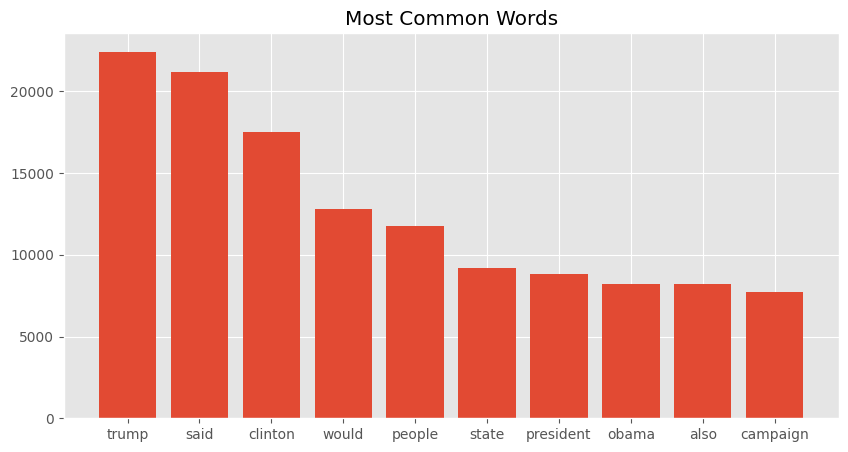

In [ ]:
# plotting common words
def plot_common_words(data):
    words = [word for news_words in data for word in news_words]

    # count the frequency
    word_counter = Counter(words)

    # select 10 most common words
    common_words = dict(word_counter.most_common(10))

    return common_words

common_words = plot_common_words(data['text'])

# plotting the common words in all data
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(common_words.keys(), common_words.values())
plt.title("Most Common Words")
plt.show()

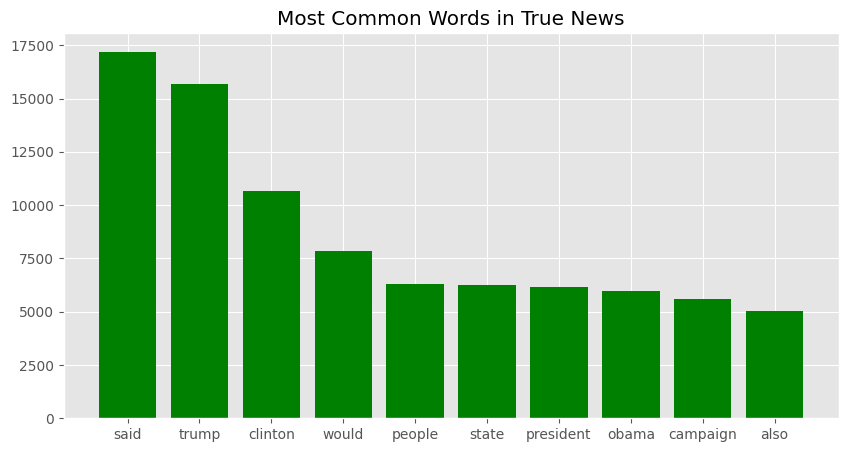

In [ ]:
true_news_data = data[data['label'] == 1]  # Filter the data where 'target' is 1 (true news)
common_words_true_news = plot_common_words(true_news_data['text'])

# plotting the common words for true news
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(common_words_true_news.keys(), common_words_true_news.values(), color='green')
plt.title("Most Common Words in True News")
plt.show()

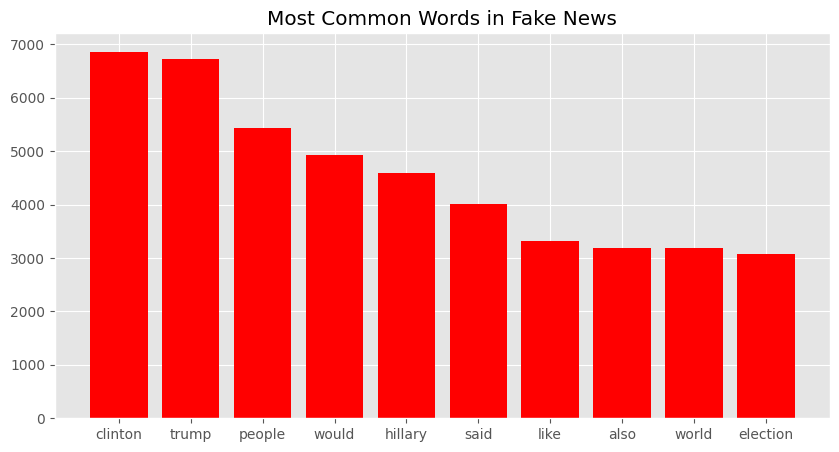

In [ ]:
fake_news_data = data[data['label'] == 0]
common_words_fake_news = plot_common_words(fake_news_data['text'])

# plotting common words for fake news
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(common_words_fake_news.keys(), common_words_fake_news.values(), color='red')
plt.title("Most Common Words in Fake News")
plt.show()

In [ ]:
# most common bigrams
def plot_common_bigrams(data):
    words = [word for news_words in data for word in news_words]

    # generate the bigrams
    bigram_list = list(bigrams(words))

    # Select the 10 most common bigrams
    bigram_counter = Counter(bigram_list)
    common_bigrams = dict(bigram_counter.most_common(10))

    return common_bigrams

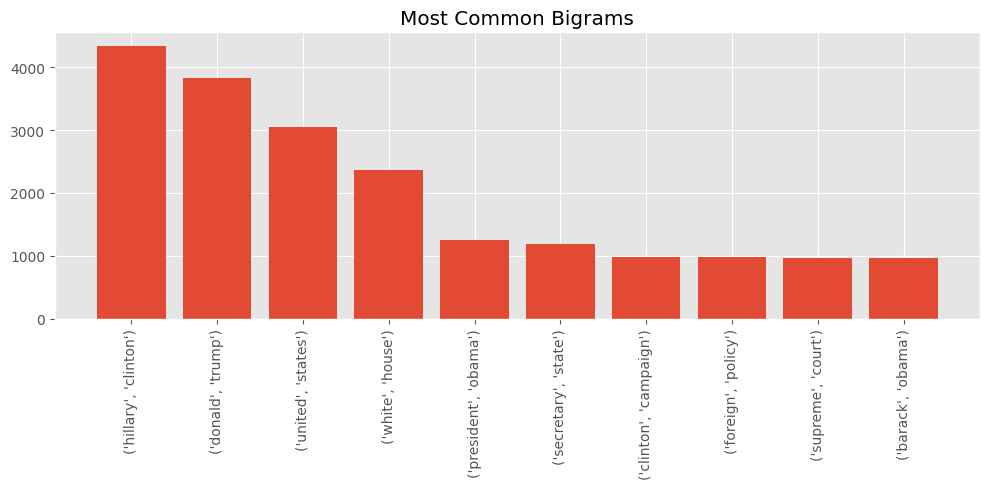

In [ ]:
common_bigrams = plot_common_bigrams(data['text'])

# plotting the common bigrams
bigram_keys = [str(key) for key in common_bigrams.keys()]

bigram_values = list(common_bigrams.values())

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(bigram_keys, bigram_values)
plt.title("Most Common Bigrams")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

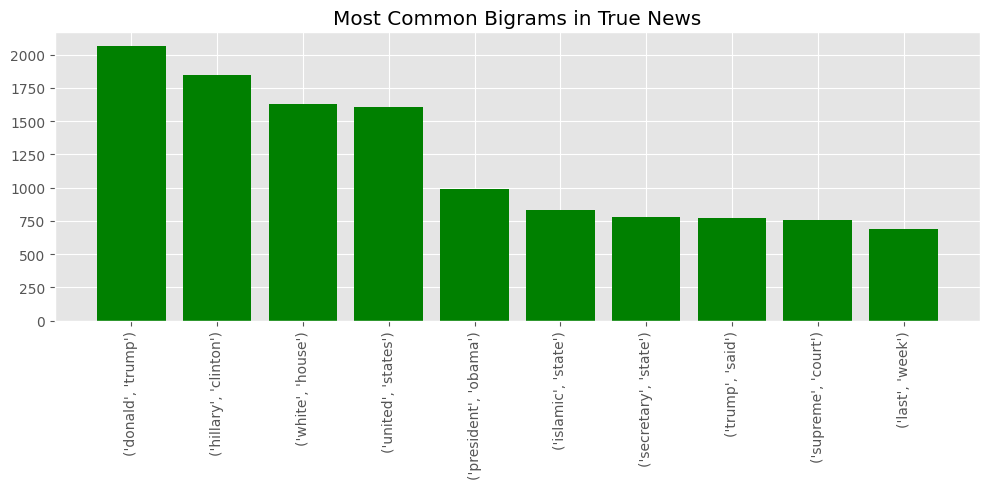

In [ ]:
true_news_data = data[data['label'] == 1]['text']
common_bigrams_true_news = plot_common_bigrams(true_news_data)

bigram_keys_true_news = [str(key) for key in common_bigrams_true_news.keys()]
bigram_values_true_news = list(common_bigrams_true_news.values())

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(bigram_keys_true_news, bigram_values_true_news, color='green')
plt.title("Most Common Bigrams in True News")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

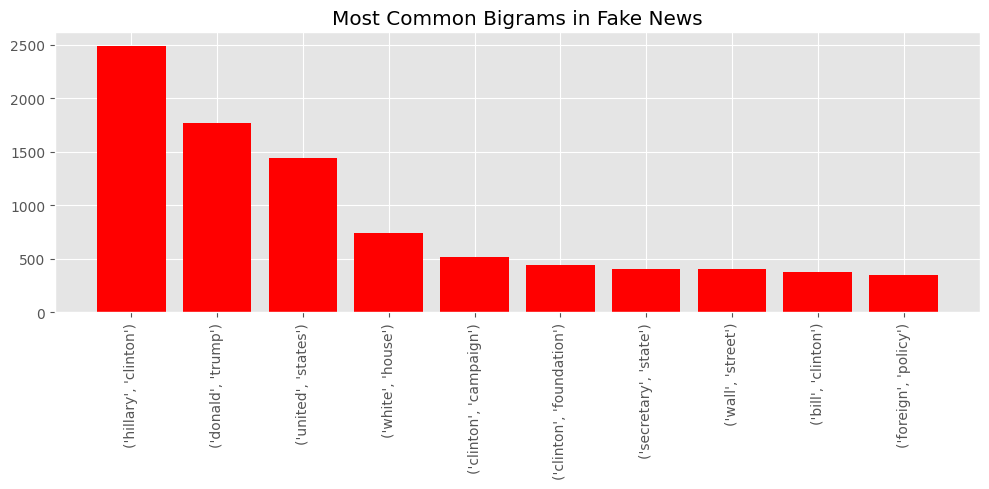

In [ ]:
fake_news_data = data[data['label'] == 0]['text']
common_bigrams_fake_news = plot_common_bigrams(fake_news_data)

bigram_keys_fake_news = [str(key) for key in common_bigrams_fake_news.keys()]
bigram_values_fake_news = list(common_bigrams_fake_news.values())

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(bigram_keys_fake_news, bigram_values_fake_news, color='red')
plt.title("Most Common Bigrams in Fake News")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Modeling

## Simple Neural Network

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer


dataset_path = '/content/drive/MyDrive/FakeNewsDataset/'

data = pd.read_csv(dataset_path + 'fake_or_real_news.csv')
data['text'] = data.apply(lambda row: f"title: {row['title']}\n{row['text']}", axis=1)

# convert label values to integers
data['label'] = data['label'].apply(lambda x: 1 if str(x) == 'REAL' else 0)

# preprocessing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])

x = tokenizer.texts_to_sequences(data['text'])
x = pad_sequences(x)

y = np.array(data['label'])
x = np.array(x)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# get the maximum length of the sequences
max_length = max(len(sequence) for sequence in x)
print(max_length)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# simple neural network
embedding_dim = 100

# Convert labels to categorical
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# define the neural network model
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Flatten(),
    layers.Dropout(0.8),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
batch_size = 32
epochs = 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

21055
Epoch 1/2
119/119 [==============================] - 541s 4s/step - loss: 2.9846 - accuracy: 0.6033 - val_loss: 0.5543 - val_accuracy: 0.6807
Epoch 2/2
119/119 [==============================] - 541s 5s/step - loss: 0.3578 - accuracy: 0.8571 - val_loss: 0.4017 - val_accuracy: 0.8236


## CNN

In [ ]:
# CNN model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer


dataset_path = '/content/drive/MyDrive/FakeNewsDataset/'

data = pd.read_csv(dataset_path + 'fake_or_real_news.csv')
data['text'] = data.apply(lambda row: f"title: {row['title']}\n{row['text']}", axis=1)

# convert label values to integers
data['label'] = data['label'].apply(lambda x: 1 if str(x) == 'REAL' else 0)

# preprocessing the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])

x = tokenizer.texts_to_sequences(data['text'])
x = pad_sequences(x)

y = np.array(data['label'])
x = np.array(x)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# get the maximum length of the sequences
max_length = max(len(sequence) for sequence in x)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

embedding_dim = 100

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

filters = 42
kernel_size = 5

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.8),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
batch_size = 32
epochs = 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/2
139/139 [==============================] - 377s 3s/step - loss: 0.6813 - accuracy: 0.5415 - val_loss: 0.6174 - val_accuracy: 0.7685
Epoch 2/2
139/139 [==============================] - 379s 3s/step - loss: 0.5667 - accuracy: 0.6940 - val_loss: 0.4044 - val_accuracy: 0.8748


In [ ]:
model.save('/content/model.h5')

# Error Analysis

In [ ]:
# Error Analysis on the CNN Model

# Make predictions using the model
y_pred_probs = model.predict(x)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create the DataFrame
df = pd.DataFrame({'X_train': data['text'], 'y_train': y, 'y_pred': y_pred})

# identify errors
df['is_error'] = df['y_train'] != df['y_pred']
error_cases = df[df['is_error']]

# number of errors and the error rate
n_errors = len(error_cases)
error_rate = n_errors / len(df)
print(f'Number of errors: {n_errors}')
print(f'Error rate: {error_rate:.2%}')

# display the training data for a given error case
def display_error_case(case_index):
    X = error_cases.iloc[case_index]['X_train']
    y_true = error_cases.iloc[case_index]['y_train']
    y_pred = error_cases.iloc[case_index]['y_pred']
    print(f'Training data: {X}')
    print(f'Target label: {y_true}')  # Corrected label output
    print(f'Prediction: {y_pred}')  # Corrected label output

# review 10 error cases
for i in range(10):
    if i >= n_errors:
        break
    print(f'Error case {i + 1}:')
    display_error_case(i)
    print()

198/198 [==============================] - 120s 605ms/step
Number of errors: 625
Error rate: 9.87%
Error case 1:
Training data: title: ‘Britain’s Schindler’ Dies at 106
A Czech stockbroker who saved more than 650 Jewish children from Nazi Germany has died at the age of 106. Dubbed “Britain’s Schindler,” Nicholas Winton arranged to transport Jewish youngsters from Prague after Germany annexed Czechoslovakia in March 1939. Though the children were originally set to arrive in Britain by plane, the German invasion forced Winton to transport them by train through Germany before they eventually reached England by boat. Winton arranged eight trains, known as the Kindertransports (children’s transports), to evacuate the children, and died on the anniversary of the 1939 departure of the one carrying the largest number of children: 241. Winton was knighted by Queen Elizabeth II in 2003 for his efforts, despite keeping it secret for nearly 50 years.
Target label: 1
Prediction: 0

Error case 2:
Tr

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels (y_true) and predicted labels (y_pred)
y_true = df['y_train']
y_pred = df['y_pred']

# Create the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[3023  141]
 [ 484 2687]]


In [ ]:
# Calculate false positives and false negatives
false_positives = len(error_cases[(error_cases['y_train'] == 0) & (error_cases['y_pred'] == 1)])
false_negatives = len(error_cases[(error_cases['y_train'] == 1) & (error_cases['y_pred'] == 0)])

# Calculate the ratio
fp_fn_ratio = false_positives / false_negatives if false_negatives != 0 else float('inf')

# Print the results
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"False Positives to False Negatives Ratio: {fp_fn_ratio:.2f}")

False Positives: 141
False Negatives: 484
False Positives to False Negatives Ratio: 0.29


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


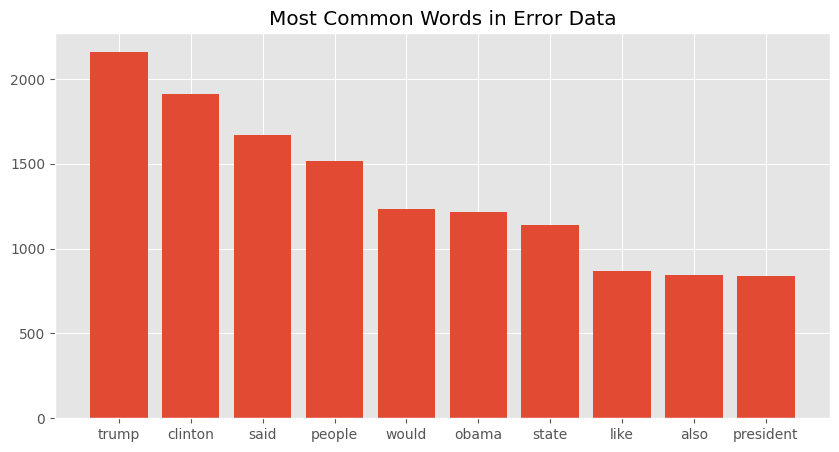

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

from nltk.tokenize import word_tokenize

def clean_data(x):
    contents = x.lower()
    contents = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", contents)

    words = word_tokenize(contents)

    stop_words = set(stopwords.words('english'))
    punctuations = set(string.punctuation)
    words = [word for word in words if word not in stop_words and word not in punctuations and len(word) >= 4]

    words = [word for word in words if word.isalpha()]

    return words

def plot_common_words(data):
    words = [word for news_text in data for word in clean_data(news_text)]

    # count the frequency
    word_counter = Counter(words)

    # select 10 most common words
    common_words = dict(word_counter.most_common(10))

    return common_words

# Extract error case texts
error_texts = error_cases['X_train'].tolist()

# Get common words in error data
common_words = plot_common_words(error_texts)

# Plotting the common words in error data
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(common_words.keys(), common_words.values())
plt.title("Most Common Words in Error Data")
plt.show()

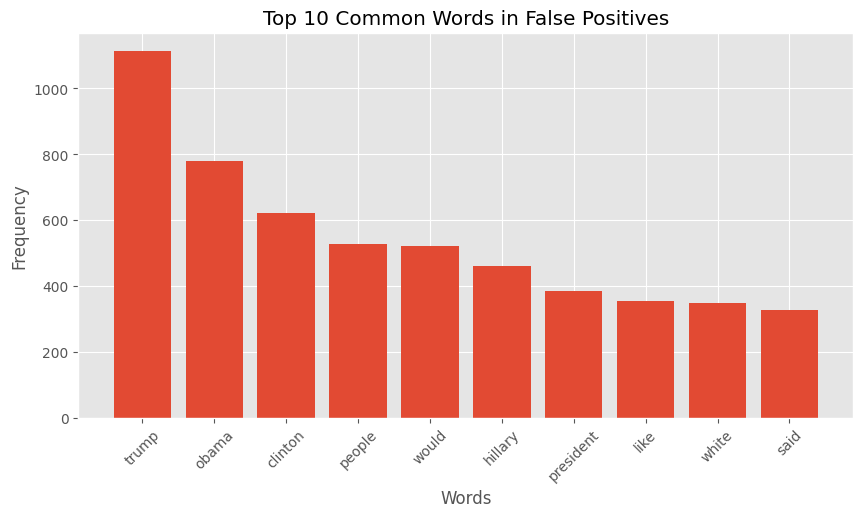

In [ ]:
def plot_common_words(data):
    words = [word for news_words in data for word in news_words]

    # Count the frequency
    word_counter = Counter(words)

    # Select 20 most common words in false negatives
    common_words = dict(word_counter.most_common(20))

    return common_words

# Filter false positives from error_cases
false_positives = error_cases[(error_cases['y_train'] == 0) & (error_cases['y_pred'] == 1)]

# Concatenate the text of false positives
false_positives_text = ' '.join(false_positives['X_train'])

# Clean the false positives text using the clean_data function
false_positives_words = clean_data(false_positives_text)

# Count the frequency of words in false positives
false_positives_word_counter = Counter(false_positives_words)

# Get the top 10 common words in false positives
top_common_words_fp = dict(false_positives_word_counter.most_common(10))

# Plot the remaining common words
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(top_common_words_fp.keys(), top_common_words_fp.values())
plt.title("Top 10 Common Words in False Positives")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


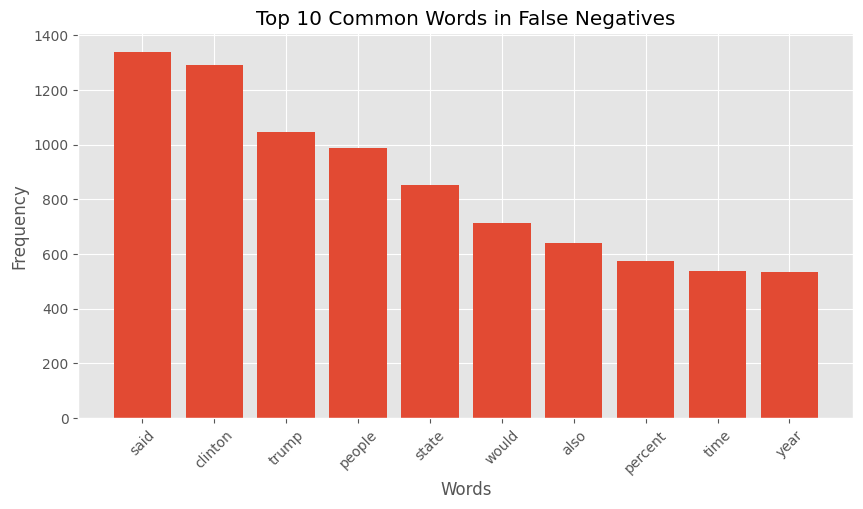

In [ ]:
def plot_common_words(data):
    words = [word for news_words in data for word in news_words]

    # Count the frequency
    word_counter = Counter(words)

    # Select 20 most common words in false negatives
    common_words = dict(word_counter.most_common(20))

    return common_words

# Filter false negatives from error_cases
false_negatives = error_cases[(error_cases['y_train'] == 1) & (error_cases['y_pred'] == 0)]

# Concatenate the text of false negatives
false_negatives_text = ' '.join(false_negatives['X_train'])

# Clean the false negatives text using the clean_data function
false_negatives_words = clean_data(false_negatives_text)

# Count the frequency of words in false negatives
false_negatives_word_counter = Counter(false_negatives_words)

# Get the top 10 common words in false negatives
top_common_words_fn = dict(false_negatives_word_counter.most_common(10))

# Plot the top 10 common words in false negatives
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(top_common_words_fn.keys(), top_common_words_fn.values())
plt.title("Top 10 Common Words in False Negatives")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(df['y_train'], df['y_pred'])

# Calculate recall
recall = recall_score(df['y_train'], df['y_pred'])

# Calculate F1 score
f1 = f1_score(df['y_train'], df['y_pred'])

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.95
Recall: 0.85
F1 Score: 0.90


The CNN model's strengths include a high precision score of 0.95, minimizing false positives, and a balanced F1 score of 0.9. However, the model's weakness lies in its recall rate of 0.85, indicating many missed positive instances. Enhancements are needed to improve recall and accurately capture all positive instances.
Overall, the model demonstrates accurate identification of true positives but requires further optimization for the comprehensive detection of fake news.